# 2. Clustering Indian Stocks using KMeans 

@techietrader

The idea is to try finding those stocks which belong to same clusters irrespective of the sector they belong. Once we find these clusters we find those stocks which are closest in distance (More on this later on) within the cluster to be later used for Pairs trading.

Here is the Flow-
1. Collection of Data and preprocessing. We are using Companies' financial performance data and also historical data to find proximity among them. We take two years daily closing data for the period 2016-18.  
2. We cluster stocks using <b>KMeans Clustering Algorithm</b>. The idea is to cover as many stocks as we can in the whole stocks gamut in India. This we can achieve by closing down the gap between Total Market Capitalization of stocks and the cumulative Market Capitalization of all the stocks that we are considering.
3. We than find those stocks inside the clusters which are closest in distance to each other using the measure called Euclidean Distance (More on this later).
4. We than run either Augmented Dickey Fuller Test or Johansen Test to figure out whether the pairs are cointegrated. We use the same historical period as above to figure that out.
5. Once we have the paris where the spread between them is stationary, we than backtest these pairs to figure out results.
6. Optimization to improve results

Part 2 & 3 above will be covered in this file.



## Prerequisites
In order to run this book on your local machine you require -
1. Python2 (Anaconda Package)- https://www.anaconda.com/download/ .
If you can manage to download individual packages on your own that should be fine too.
2. Seaborn. - https://seaborn.pydata.org/ .  For better visualization


## About me
I am an Individual trader who loves to try researching new strategies. 

I m not associated with anyone mentioned in prerequisites above

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk

print pd.__version__
print np.__version__
print sns.__version__
print sk.__version__

0.20.3
1.15.0
0.7.1
0.19.0


## Import Libraries


### Data Analysis

In [2]:
import numpy as np
import pandas as pd
np.set_printoptions(suppress=True, formatter={'float_kind':'{:0.2f}'.format})
# Ignore any warnings that you might get while importing

### Visualization

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE  # Helps visualize higher dimensions data
import missingno as msno # Missing Data visualization

sns.set(style="white")
%matplotlib inline

### Sklearn (Machine Learning framework)

In [4]:
from sklearn.decomposition import PCA # Helps reduce dimensions and also solves problem of multicollinearity.
from sklearn.preprocessing import StandardScaler  # Helps us in Standardizing the data
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors

### Miscellaneous

In [5]:
from datetime import datetime
from collections import Counter
import time

## Importing Files

### Financial Data

In [7]:
fin_data = pd.read_excel('Financial_data.xlsx', index_col= 'Ticker')

### Futures & Options List

In [8]:
f_n_o_list = pd.read_excel('FnO_list.xlsx', index_col='Symbol')
f_n_o_list = list(f_n_o_list.index)
f_n_o_list = [scrip for scrip in f_n_o_list if scrip in fin_data.index]

### Returns' data

In [9]:
returns_data = pd.read_excel('Returns_data.xlsx', index_col= 'Date')
returns_data.dropna(inplace= True)

In [10]:
# lets bring the dataframes we want to merge on same index
returns_data_t = returns_data.T.sort_index(ascending= True)
returns_data_t.index.name = 'Ticker'

fin_data = fin_data.sort_index(ascending= True)

In [11]:
print returns_data.T.shape
print fin_data.shape

(968, 492)
(968, 11)


In [12]:
# A small check whether all the rows match in the pricing and fin_data DFs
for i , j in zip(fin_data.index,returns_data_t.index):
    if i != j :
        print i, j
# Printed nothing

In [13]:
f_n_o_list[0:7]

[u'ACC',
 u'ADANIENT',
 u'ADANIPORTS',
 u'ADANIPOWER',
 u'AJANTPHARM',
 u'ALBK',
 u'AMARAJABAT']

## Lets look at the Market Capitalization we are covering

#### Marketcap of $2.29 Trillion 

In [14]:
Total_Market_Cap = 2.29 * 1000 * 1000 * 1000000 * 68

Makret_Cap_we_covering = fin_data['Market Cap'].sum() * 10000000


In [15]:
print 'We are covering {} % of Total Market Cap already'.format(round((Makret_Cap_we_covering / Total_Market_Cap)*100,2))

We are covering 89.22 % of Total Market Cap already


### Great!

The Market cap of $2.29 Trillion dates back to late 2017, whereas the financial data that we have is of recent date. The market cap that we shall be covering in our analysis should not be significantly less but less than <b>overall Market Cap</b>. Here is the article for reference - https://www.bloomberg.com/news/articles/2017-11-30/indian-stock-market-overtakes-canada-in-2-trillion-standoff

## Time to move on with Machine Learning!

In [16]:
# Standardization. To bring everything on same scale
std = StandardScaler()
X_fin_data = pd.DataFrame(std.fit_transform(fin_data), index = fin_data.index, columns = fin_data.columns)

In [17]:
X_fin_data.head() #Standardized Financial Data

,Sub-Sector,Market Cap,PE Ratio,Return on Equity,Net Profit Margin,Return on Investment,1Y Historical Revenue Growth,1Y Historical EPS Growth,EBITDA,Cash and Equivalent,Total Debt
Ticker,,,,,,,,,,,
3IINFOTECH,-1.453711,-0.267467,-0.146145,0.289669,0.024271,-0.134751,-0.114285,-0.089665,-0.188809,-0.190044,-0.236362
3MINDIA,0.242333,0.236116,0.394492,0.167719,0.113461,0.859914,-0.081213,-0.032000,-0.114113,-0.140323,-0.267607
8KMILES,-0.035202,-0.259795,-0.166575,0.402052,0.336490,2.409075,0.211185,-0.003807,-0.329395,-0.200389,-0.263973
A2ZINFRA,-1.176177,-0.270937,-0.228661,-0.455301,-0.333861,-1.157642,-0.258647,-0.044459,-0.190828,-0.172539,-0.211860
AARTIDRUGS,-1.052828,-0.253072,-0.097753,0.129497,0.012237,0.169119,-0.117960,-0.052845,-0.172552,-0.203595,-0.249596


In [18]:
returns_data_t.head()

Date,2016-04-04 00:00:00,2016-04-05 00:00:00,2016-04-06 00:00:00,2016-04-07 00:00:00,2016-04-08 00:00:00,2016-04-11 00:00:00,2016-04-12 00:00:00,2016-04-13 00:00:00,2016-04-18 00:00:00,2016-04-20 00:00:00,...,2018-03-15 00:00:00,2018-03-16 00:00:00,2018-03-19 00:00:00,2018-03-20 00:00:00,2018-03-21 00:00:00,2018-03-22 00:00:00,2018-03-23 00:00:00,2018-03-26 00:00:00,2018-03-27 00:00:00,2018-03-28 00:00:00
Ticker,,,,,,,,,,,,,,,,,,,,,
3IINFOTECH,0.011364,-0.044944,0.011765,0.000000,0.011628,-0.022989,-0.023529,0.012048,0.011905,0.023529,...,-0.029126,-0.050000,-0.042105,0.021978,0.043011,0.041237,0.000000,0.000000,0.000000,0.000000
3MINDIA,-0.005505,-0.006771,0.000589,-0.018935,0.051423,0.028296,0.165623,0.029798,0.006731,0.026657,...,-0.002307,-0.003896,-0.015126,-0.004089,-0.003968,-0.000031,-0.016052,-0.009492,0.000457,0.019414
8KMILES,-0.005313,-0.037508,0.027173,-0.017392,-0.005960,-0.015893,-0.023266,0.044979,-0.002650,0.032324,...,0.001348,-0.015016,-0.029484,-0.010596,0.034150,0.002897,-0.024117,-0.008731,0.014555,-0.014052
A2ZINFRA,0.002398,-0.009569,0.198068,0.042339,0.048356,0.031365,-0.026834,-0.011029,-0.037175,0.015444,...,0.026359,-0.012841,-0.040650,-0.010169,-0.015411,-0.053913,-0.027574,-0.022684,0.067698,-0.043478
AARTIDRUGS,-0.001732,-0.008023,-0.009619,0.000441,-0.000221,0.008827,0.015203,0.003555,0.008588,0.002980,...,0.044044,-0.026886,-0.016995,-0.022652,-0.002176,-0.002560,-0.024047,-0.018309,0.023909,-0.019475


In [19]:
print X_fin_data.shape 
print returns_data_t.shape

(968, 11)
(968, 492)


### Finding Principal Components for our tickers that explain highest Variance in dataset

A very nice Step-by-Step guide to Principal Component Analysis is given by Josh Starmer on his youtube channel [here](https://www.youtube.com/watch?v=FgakZw6K1QQ)

#### Lets combine the above two Dfs to create our final input

In [20]:
final_df = pd.merge(X_fin_data, returns_data_t, left_index= True, right_index= True)

In [21]:
final_df.shape # Merged Columns on same index

(968, 503)

In [22]:
final_df.head()

,Sub-Sector,Market Cap,PE Ratio,Return on Equity,Net Profit Margin,Return on Investment,1Y Historical Revenue Growth,1Y Historical EPS Growth,EBITDA,Cash and Equivalent,...,2018-03-15 00:00:00,2018-03-16 00:00:00,2018-03-19 00:00:00,2018-03-20 00:00:00,2018-03-21 00:00:00,2018-03-22 00:00:00,2018-03-23 00:00:00,2018-03-26 00:00:00,2018-03-27 00:00:00,2018-03-28 00:00:00
Ticker,,,,,,,,,,,,,,,,,,,,,
3IINFOTECH,-1.453711,-0.267467,-0.146145,0.289669,0.024271,-0.134751,-0.114285,-0.089665,-0.188809,-0.190044,...,-0.029126,-0.050000,-0.042105,0.021978,0.043011,0.041237,0.000000,0.000000,0.000000,0.000000
3MINDIA,0.242333,0.236116,0.394492,0.167719,0.113461,0.859914,-0.081213,-0.032000,-0.114113,-0.140323,...,-0.002307,-0.003896,-0.015126,-0.004089,-0.003968,-0.000031,-0.016052,-0.009492,0.000457,0.019414
8KMILES,-0.035202,-0.259795,-0.166575,0.402052,0.336490,2.409075,0.211185,-0.003807,-0.329395,-0.200389,...,0.001348,-0.015016,-0.029484,-0.010596,0.034150,0.002897,-0.024117,-0.008731,0.014555,-0.014052
A2ZINFRA,-1.176177,-0.270937,-0.228661,-0.455301,-0.333861,-1.157642,-0.258647,-0.044459,-0.190828,-0.172539,...,0.026359,-0.012841,-0.040650,-0.010169,-0.015411,-0.053913,-0.027574,-0.022684,0.067698,-0.043478
AARTIDRUGS,-1.052828,-0.253072,-0.097753,0.129497,0.012237,0.169119,-0.117960,-0.052845,-0.172552,-0.203595,...,0.044044,-0.026886,-0.016995,-0.022652,-0.002176,-0.002560,-0.024047,-0.018309,0.023909,-0.019475


### PCA

In [23]:
pca = PCA(n_components= 7) # 7 PCs explains good variance

In [24]:
final_X = pca.fit_transform(final_df.values)

In [25]:
print pca.explained_variance_ratio_.sum() # 80% of variance is explained by 7 Principal componenets instead of 503.

0.8060083426868375


In [26]:
print final_X.shape

(968L, 7L)


### Tuning the Hyperparameters 
Elbow method is really nice way to find optimal value of K in kmeans clustering

In [27]:
variance = []
for k in range(1, 75): # 125 is the number of sectors
    km = KMeans(n_clusters=k, 
                )
    km.fit(final_X)
    variance.append(km.inertia_)



Text(0.5,1,'Elbow')

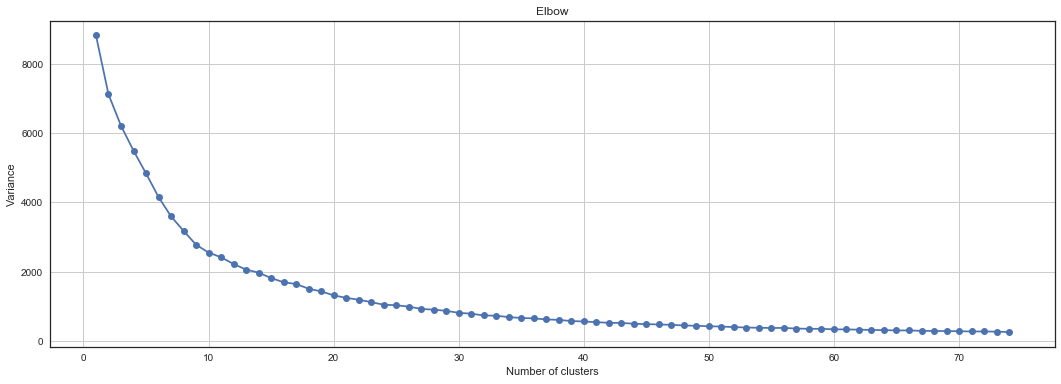

In [28]:
plt.figure(figsize = (18,6))
plt.plot(range(1, 75), variance, marker='o')
plt.grid()
plt.xlabel('Number of clusters')
plt.ylabel('Variance')
plt.title('Elbow')

### Lets choose k as 40

In [29]:
km = KMeans(n_clusters=40,init= 'random', max_iter= 800,n_init= 300,algorithm= 'elkan', random_state= 5)
km.fit(final_X)
df_clustered = pd.DataFrame(km.labels_, fin_data.index)

labels = km.labels_


clustered_series = pd.Series(index=fin_data.index, data=labels)
clustered_series.value_counts().head()

14    93
12    84
25    83
17    74
8     65
dtype: int64

#### t-distributed stochastic neighbor embedding (TSNE)
Tsne is machine learning algorithm technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets.

In [30]:
# Ignore Warning

X_tsne = TSNE(learning_rate=1000, perplexity=25, random_state=1337).fit_transform(final_X)
X_tsne_df = pd.DataFrame(X_tsne, columns = ['X_tsne_1', 'X_tsne_2'])
X_tsne_df['labels'] = labels

In [31]:
X_tsne_df.head()

,X_tsne_1,X_tsne_2,labels
0,35.403027,33.226315,2
1,-25.092728,9.276802,37
2,-18.070227,33.548325,36
3,16.595499,-20.006189,20
4,33.223194,27.498558,2


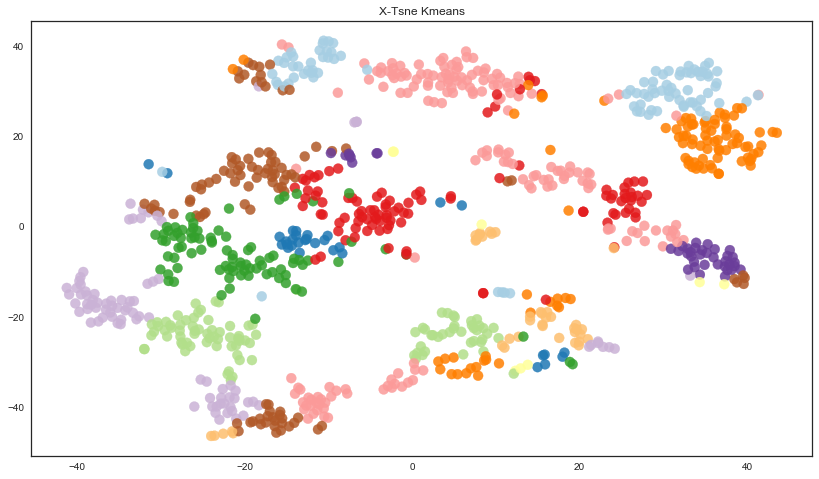

In [32]:
# Create the figure
fig = plt.figure( figsize=(14,8))
ax = fig.add_subplot(1, 1, 1, title='X-Tsne Kmeans' )
# Create the scatter
ax.scatter(
    x=X_tsne_df['X_tsne_1'], 
    y=X_tsne_df['X_tsne_2'], 
    c=X_tsne_df['labels'], 
    cmap=plt.cm.get_cmap('Paired'), 
    alpha=0.85,
    s=100)

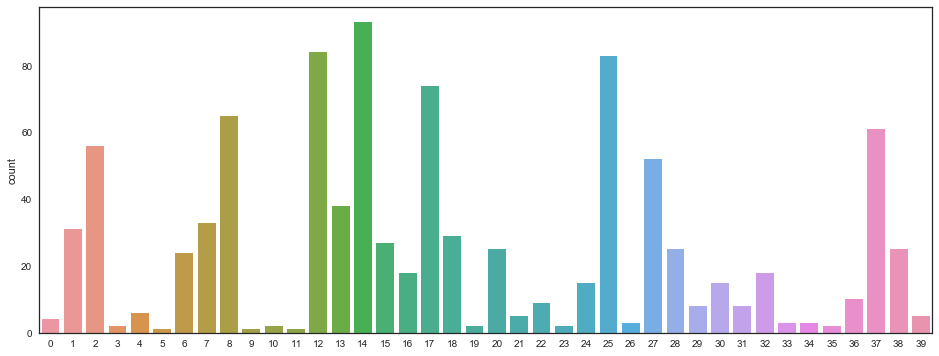

In [33]:
# Number of stocks in each cluster
plt.figure(figsize= (16,6))
sns.countplot(x = clustered_series.index, data =clustered_series)
plt.xlabel = 'Number of Clusters'
plt.ylabel = 'Number of Stocks in each CLuster'


Clustering helps us to figure out the stocks that are closest in distance to each other. It helps us reduce the brute force tries on all the pairs. Here is the example - 
Suppose we want to try a brute force method and we have 968 stocks, what we have to attempt in Brute Force technique is-
<img src="https://latex.codecogs.com/svg.latex?\Large&space;TotalNumberofPairs=\frac{n*{(n-1)}}{2}" title="\Large Total Number of Pairs = \frac{n* {(n-1)}}{2}" />

In [34]:
print 'So total number of pairs we have to attempt is : {}'.format((
    len(returns_data.columns) * (len(returns_data.columns) -1)) /2)

So total number of pairs we have to attempt is : 468028


#### Thats a lot of combinations. This is where Clustering comes in handy. We only try conintegration on those many pairs of stocks that fall in same clusters, this not only reduces time and computational complexity but also gives accurate results

In [35]:
# Clusters Discovered
counts = clustered_series.value_counts()
ticker_count_reduced = counts[counts>1] # This eliminates clusters where their is only one stock
print "Clusters formed: %d" % len(ticker_count_reduced)
print "Pairs to evaluate: %d" % (ticker_count_reduced*(ticker_count_reduced-1)).sum()

Clusters formed: 37
Pairs to evaluate: 49962


But lets just stick to FnO listed Stocks and find number of pairs to be tested for cointegration

In [36]:
relevant_stocks = [stock for stock in f_n_o_list if stock in returns_data.columns]
print 'Total number of stocks :- {}'.format(len(relevant_stocks))
print '\n'
print 'So total number of pairs we have to attempt for cointegration in brute force is = {}'.format((
    len(relevant_stocks) * (len(relevant_stocks) -1)) /2)

Total number of stocks :- 197


So total number of pairs we have to attempt for cointegration in brute force is = 19306


In [37]:
clusters_f_n_o = clustered_series[f_n_o_list]

In [38]:
# Clusters Discovered for FnO Segment
clusters_values = clusters_f_n_o.value_counts()
clusters_with_atleast_2_stocks = clusters_values[clusters_values > 1] # This eliminates clusters which less than 2 stocks in it
print 'Clusters formed: {}'.format(len(clusters_with_atleast_2_stocks))
print 'Pairs to evaluate: {}'.format((clusters_with_atleast_2_stocks*(clusters_with_atleast_2_stocks-1)).sum())

Clusters formed: 21
Pairs to evaluate: 2558


In [39]:
clusters_f_n_o.head() # Its a series with stock symbol and the cluster it belongs to

Ticker
ACC           18
ADANIENT      12
ADANIPORTS    16
ADANIPOWER    16
AJANTPHARM     1
dtype: int32

#### Woow! We reduced attempts from 19306 to mere 2558

#### Lets try and check accuracy of our clusters using the Sector column. As discussed prior, we want stocks in same sector to fall in same cluster

In [40]:
fin_data['Sub-Sector'].value_counts().head() # Index is sector number and the value is the number of companies in that
                                             # sector

30    52
13    47
9     43
83    36
26    33
Name: Sub-Sector, dtype: int64

30th mapped sector has 52 companies. Lets just check accuracy

In [41]:
dense_sector = list(fin_data[fin_data['Sub-Sector'] == 30].index)
print dense_sector[0:6], len(dense_sector)

[u'ALICON', u'ASAHIINDIA', u'AUTOAXLES', u'BANCOINDIA', u'BOSCHLTD', u'DYNAMATECH'] 52


In [42]:
print clustered_series[dense_sector].head(10)
clustered_series[dense_sector].value_counts().max() / float(clustered_series[dense_sector].value_counts().sum()) *100

Ticker
ALICON        14
ASAHIINDIA    14
AUTOAXLES     14
BANCOINDIA    14
BOSCHLTD      15
DYNAMATECH    22
FIEMIND       14
FMGOETZE      14
GABRIEL       14
GANDHITUBE    14
dtype: int32


71.15384615384616

71.15% of the stock in that sector was accurately clustered

### Lets check accuracy for FnO stocks and their sectors

In [43]:
fin_data_sector = fin_data['Sub-Sector']
fin_data_sector = fin_data_sector[f_n_o_list]

In [44]:
# No. of unique sector for FnO stocks
fin_data_sector.nunique()

75

In [45]:
fin_data_sector.head(5)

Ticker
ACC           17
ADANIENT      60
ADANIPORTS    24
ADANIPOWER    15
AJANTPHARM    13
Name: Sub-Sector, dtype: int64

In [46]:
# lets find accuracy for top 10 dense sector
company_sector =  []
top_10_dense_sector = fin_data_sector.value_counts().head(10)
for num in top_10_dense_sector.index:
    company_sector = list(fin_data_sector[fin_data_sector == num].index)
    print 'Total Number of companies in sector {} is {}'.format(int(num),len(company_sector))

    temp = clusters_f_n_o[company_sector].value_counts()
    print 'The accuracy in clustering stocks is {} %'.format(round(temp.max() / float(temp.sum()) *100),3)
    print '\n'

Total Number of companies in sector 13 is 13
The accuracy in clustering stocks is 31.0 %


Total Number of companies in sector 7 is 12
The accuracy in clustering stocks is 50.0 %


Total Number of companies in sector 2 is 11
The accuracy in clustering stocks is 27.0 %


Total Number of companies in sector 0 is 9
The accuracy in clustering stocks is 44.0 %


Total Number of companies in sector 17 is 9
The accuracy in clustering stocks is 33.0 %


Total Number of companies in sector 11 is 9
The accuracy in clustering stocks is 33.0 %


Total Number of companies in sector 9 is 7
The accuracy in clustering stocks is 29.0 %


Total Number of companies in sector 1 is 6
The accuracy in clustering stocks is 17.0 %


Total Number of companies in sector 5 is 5
The accuracy in clustering stocks is 40.0 %


Total Number of companies in sector 26 is 5
The accuracy in clustering stocks is 40.0 %




#### Figures are dismal

### Now Lets plot a few stocks from a few clusters to check their price movements and relation
For this we will start plotting stocks by reindexing them to 0 to also find outperforming stocks within the cluster

In [47]:
pricing_data = pd.read_excel('Pricing_data.xlsx', index_col= 'Date')

In [48]:
# Final number of clusters for FnO segment
clusters_with_atleast_2_stocks.head()

15    25
18    23
32    18
16    17
30    15
dtype: int64

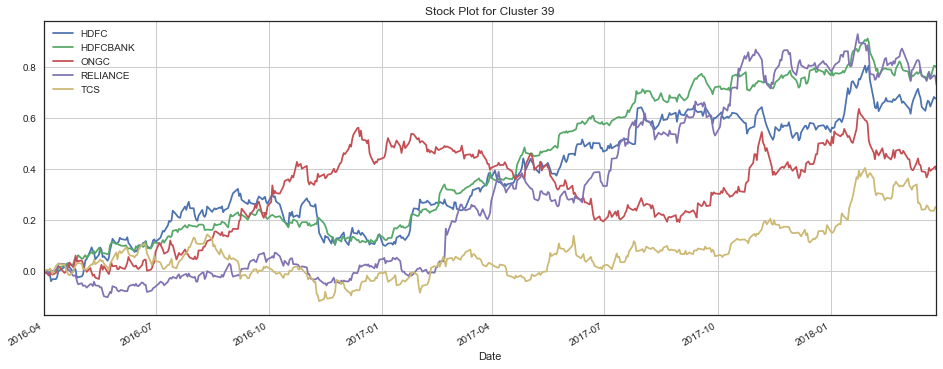

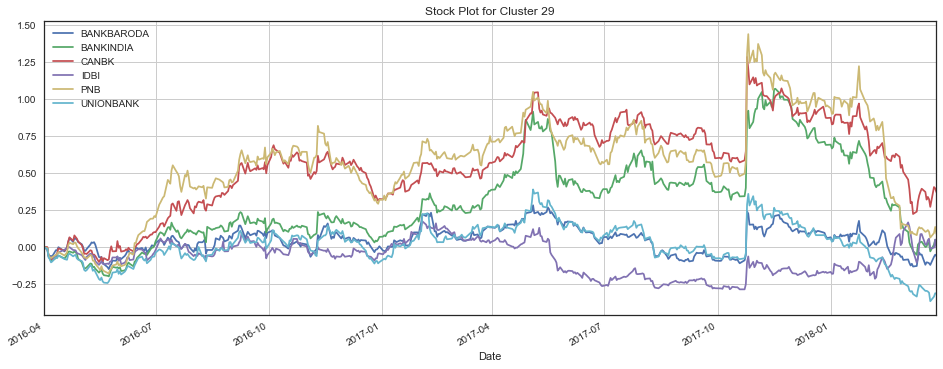

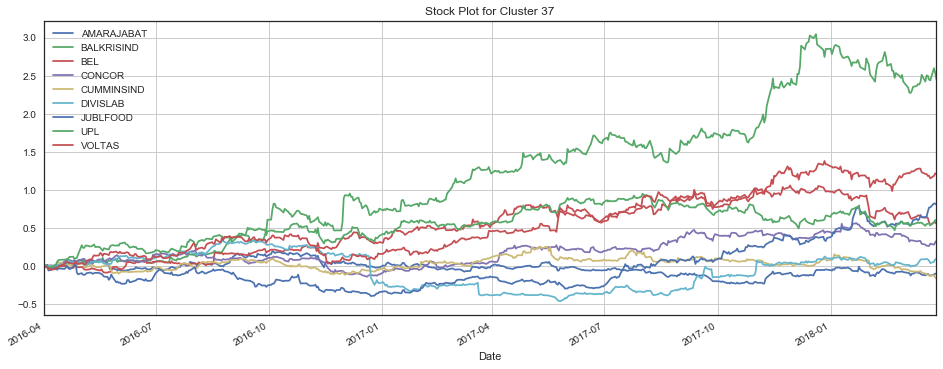

In [49]:
# Lets just randomly choose clusters to plot
clusters_plot = [39,29,37]

# Plotting

for num in clusters_plot:
    stocks = list(clusters_f_n_o[clusters_f_n_o==num].index)
    data = pricing_data[stocks].apply(lambda x: (x - x[0])/x[0] )
    data.plot(figsize=(16,6),grid=True, title='Stock Plot for Cluster {}'.format(num) )


#### Seems a mix bag. Some are outperforming , some closesly follow each other, etc, etc, etc....

### Final Step!
Finding pairs from each 21 cluster which has highest proximity. In other words finding stocks that are closest in distance

Lets just briefly look as to what we are doing below.

Knearest neigbors algorithm uses same distance metric to find proximity among elements. We used it to figure out the closest neighbor to each stock in the list. Lets understand this by an example of 3 points on a number line-
<img src="number_line.png">

Lets say we have three elements in a cluster. KNN algorithm finds the elements nearest to every element using Euclidean distance depending upon the number of K value we specify. So in this example we will have -
1.  <b>A, B</b>
2.  <b>B, C</b>
3.  <b>C, B</b>

Though they all belong to same cluster we would be more interested in finding those items in a pair we are closest to each other. In this case B and C

So the idea is first we find stock closest to each n every stock and then filter them out on basis of Futures and Options List

In [50]:
NN =NearestNeighbors(n_neighbors=2 , metric= 'euclidean').fit(pd.DataFrame(final_X, index = final_df.index))

In [51]:
distances, indices = NN.kneighbors(pd.DataFrame(final_X, index = final_df.index), n_neighbors=2)

In [52]:
indices[0:5] # [0,1,2,3,4] are the indices of the stocks as shown below. 
             # [885,357,846,955,485] are the indices of stocks that are closest in distance to above indices

array([[  0, 885],
       [  1, 357],
       [  2, 846],
       [  3, 955],
       [  4, 485]], dtype=int64)

In [53]:
final_pairs_df = pd.DataFrame(clustered_series, columns= ['Cluster_number'])

In [54]:
final_pairs_df.head()

,Cluster_number
Ticker,
3IINFOTECH,2
3MINDIA,37
8KMILES,36
A2ZINFRA,20
AARTIDRUGS,2


In [55]:
final_pairs_df = final_pairs_df.reset_index().join(
    pd.DataFrame(indices)[1]).set_index('Ticker') # Adds new column of the index of the stock closest to the index stock

final_pairs_df.rename(columns= {1 : 'Nearest_Neighbors_Index'},inplace= True) # Rename column

final_pairs_df['Nearest_Neighbor'] = final_pairs_df.index[final_pairs_df['Nearest_Neighbors_Index']] # Extracting name of 
                                                                                                 # stock using index values

final_pairs_df = final_pairs_df.loc[f_n_o_list] # Considering stocks only part of FnO List

final_pairs_df = final_pairs_df.reset_index().set_index(['Cluster_number', 'Ticker']).sort_index() # Multi Indexing

final_pairs_df.drop('Nearest_Neighbors_Index', axis = 1, inplace= True) # Not required now

In [56]:
final_pairs_df.head()

Nearest_Neighbor
Cluster_number Ticker                     
1              AJANTPHARM       ABBOTINDIA
               COLPAL            BAJAJCORP
               MARICO                 PGHH
               OFSS                 VIPIND
               PAGEIND           TATAELXSI

In [57]:
print final_pairs_df.shape

(197, 1)


#### The nearest neighbor column has stocks from non-FnO list. So lets drop those rows as well

In [58]:
final_pairs_df = final_pairs_df[final_pairs_df['Nearest_Neighbor'].isin(f_n_o_list)]

In [59]:
final_pairs_df.head()

Nearest_Neighbor
Cluster_number Ticker                     
1              PAGEIND           TATAELXSI
2              GLENMARK         MANAPPURAM
               MANAPPURAM         GLENMARK
               MINDTREE           HEXAWARE
12             ADANIENT           SREINFRA

In [60]:
final_pairs_df.to_csv('Pairs.csv')